In [1]:
from models.vit_edited import vit_base_patch16_224
import matplotlib.pyplot as plt
from classIdx import CLS2IDX
import torchvision
from FovEx import *
import glob

Random seed set as 42


In [2]:
SEED = 42
# FovEx Paramters
lr = 0.1
blur_sigma = 10 
forgetting = 0.1
image_size = 224
scanpath_length = 10
blur_filter_size = 41 
foveation_sigma = 0.15
random_restart = True
optimization_steps = 20
heatmap_sigma=0.15
heatmap_forgetting = scanpath_length*[1.0]
normalize_heatmap=True

In [3]:
criterion = torch.nn.CrossEntropyLoss(reduction="none")
def target_function(x, y):
    return y

In [4]:
# Load Model
model = vit_base_patch16_224(pretrained=True,pretrained_cfg=True).cuda()
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (fc_norm): Identity()
  (head): Linear(in_features=768, out_features=1000, bias=True)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
     

In [5]:
# Create FovEx instance
fovex = FovExWrapper(downstream_model=model,
                    criterion=criterion,
                    target_function=target_function,
                    image_size=image_size,
                    foveation_sigma=foveation_sigma,
                    blur_filter_size=blur_filter_size,
                    blur_sigma=blur_sigma,
                    forgetting=forgetting,
                    foveation_aggregation=1,
                    heatmap_sigma=heatmap_sigma,
                    heatmap_forgetting=heatmap_forgetting,
                    device='cuda'
                    )

In [6]:
# Read image
image_path = './images/ILSVRC2012_val_00003112.JPEG'
image = read_img(image_path)
images = torchvision.transforms.Resize((image_size, image_size), antialias=True)(image)/255.0
images = images[None].cuda()

In [7]:
# Get model predictions
prediction = model(images).squeeze(0).softmax(0)
top5 = torch.topk(prediction, k=5, dim=0).indices
pred_labels = top5[0].unsqueeze(0)

In [8]:
# Generate explanation
explantion, fixation_points, current_loss_history, internal_rep = fovex.generate_explanation(
                                                                                            images, 
                                                                                            pred_labels, 
                                                                                            scanpath_length, 
                                                                                            optimization_steps, 
                                                                                            lr, 
                                                                                            random_restart,
                                                                                            normalize_heatmap
                                                                                            )

Random seed set as 42


/home/woody/iwso/iwso089h/envs/thesis/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


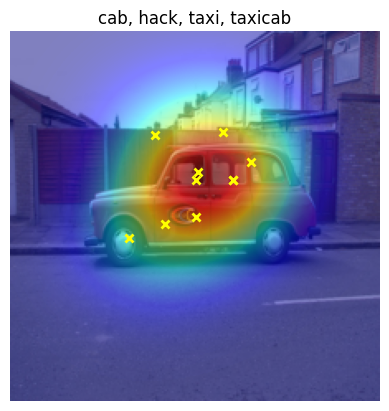

In [9]:
# Plotting the explanation
scale=image_size//2
prediction = CLS2IDX[pred_labels.item()]
y = scale*fixation_points[:, 0].cpu() + scale
x = scale*fixation_points[:, 1].cpu() + scale

plt.imshow(images[0].cpu().permute(1,2,0))
plt.imshow(explantion[0, 0].cpu(), alpha=0.5, cmap='jet')
plt.plot(x, y, 'x ', markersize=6, mew=2, color='yellow')
plt.axis('off')
plt.title(prediction)
plt.show()

In [10]:
# all image paths
image_paths = glob.glob('./images/*.JPEG')

In [11]:
gt_images = []
explanation_maps = []
fixations_points= []
predictions = []

for i in range(len(image_paths)):
    # read image
    image = read_img(image_paths[i])
    images = torchvision.transforms.Resize((image_size, image_size), antialias=True)(image)/255.0
    gt_images.append(images.permute(1, 2, 0))
    images = images[None].cuda()
    # generate prediction
    prediction = model(images).squeeze(0).softmax(0)
    top5 = torch.topk(prediction, k=5, dim=0).indices
    pred_labels = top5[0].unsqueeze(0)
    # generate explanation
    explanation, fixations, current_loss_history, internal_rep = fovex.generate_explanation(
                                                                                            images, 
                                                                                            pred_labels, 
                                                                                            scanpath_length, 
                                                                                            optimization_steps, 
                                                                                            lr, 
                                                                                            random_restart,
                                                                                            normalize_heatmap
                                                                                            )
    
    predictions.append(CLS2IDX[pred_labels.item()])
    explanation_maps.append(explanation[0, 0].cpu())
    fixations_points.append(fixations.cpu())
    

Random seed set as 42
Random seed set as 42
Random seed set as 42
Random seed set as 42


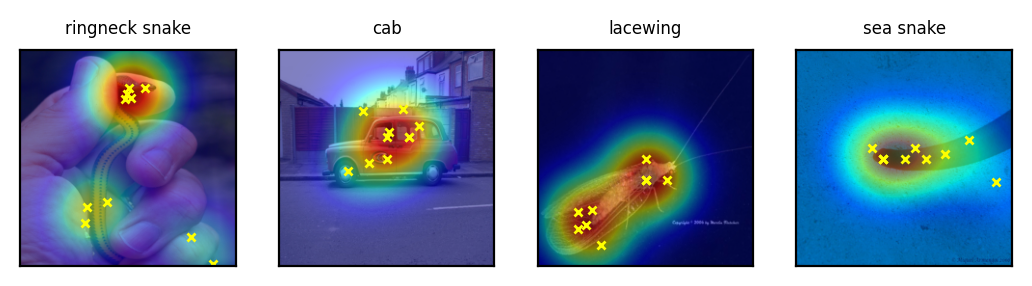

In [12]:
fig, ax = plt.subplots(1, len(gt_images), dpi=200)
ax = ax.ravel()

for i in range(len(ax)):
    ax[i].imshow(gt_images[i])
    ax[i].imshow(explanation_maps[i], cmap='jet', alpha=0.5)
    
    y = scale*fixations_points[i][:, 0].cpu() + scale
    x = scale*fixations_points[i][:, 1].cpu() + scale
    ax[i].plot(x, y, 'x ', markersize=3, mew=1, color='yellow')
    
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(predictions[i].split(',')[0], fontsize=6)
    
plt.show()